# defaulting

https://scanpy.readthedocs.io/en/stable/api/index.html
https://docs.google.com/spreadsheets/d/1V_3uDvxbt93x6eadEglJt37TlN6LJGtz6p3ElleBnAU/edit?gid=2113286836#gid=2113286836

In [89]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 로깅 설정 (선택 사항, 진행 상황 및 경고 표시)
sc.settings.verbosity = 3             # verbosity: 3 = 오류, 경고, 정보 표시
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# loading & metadata join.

In [168]:
url_h5="/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cell_feature_matrix.h5"
url_parquet_cells="/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet"
url_parquet_boundaries="/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cell_boundaries.parquet"
url_cores="/data/ARPAH/250210_CRC_BJM/cell_ID/slide2(0050585)_Region1"

In [91]:


adata=sc.read_10x_h5(url_h5)
adata.uns["1.var_len_raw"]=len(adata.var_names)
adata.var_names_make_unique()  # 중복된 유전자 이름 처리
adata.uns["2.var_len_unique"]=len(adata.var_names)

cells_df = pd.read_parquet(url_parquet_cells)
print(cells_df)
# AnnData의 obs 인덱스와 cells_df의 cell_id가 일치하는지 확인 필요
# 만약 다르다면, cells_df의 인덱스를 cell_id로 설정
if 'cell_id' in cells_df.columns:
    cells_df = cells_df.set_index('cell_id')
print(cells_df)

# AnnData의 obs 인덱스와 정렬하여 메타데이터 추가
adata.obs = adata.obs.join(cells_df, how='left',lsuffix="_adata",rsuffix="_cells_df")

# 공간 좌표 추가 (x_centroid, y_centroid 컬럼 이름 확인 필요)
if 'x_centroid' in adata.obs.columns and 'y_centroid' in adata.obs.columns:
    adata.obsm['spatial'] = adata.obs[['x_centroid', 'y_centroid']].to_numpy()
else:
    print("Warning: Could not find 'x_centroid' or 'y_centroid' in adata.obs to populate adata.obsm['spatial']")
    # 필요시 다른 좌표 컬럼 사용 (예: fov_x, fov_y - 이는 FOV 내 상대좌표일 수 있음)

import glob, re
conflict_report = []
core_list=glob.glob(os.path.join(url_cores, '*_cells_stats.csv'))
for core_url in core_list:
    # 파일명에서 core 번호 추출
    basename = os.path.basename(core_url)  # '13_cells_stats.csv'
    match = re.match(r"(\d+)_cells_stats\.csv", basename)
    if not match:
        print(f"[WARNING] Cannot extract Core ID from filename: {core_url}")
        continue
    core_id = match.group(1)  # '13'

    # 데이터 읽기
    core = pd.read_csv(core_url, comment="#", skip_blank_lines=True)
    if 'Cell ID' not in core.columns:
        print(f"[WARNING] 'Cell ID' column not found in {core_url}. Skipping.")
        continue
    core = core.set_index("Cell ID")

    # Core ID column 추가
    core["Core"] = core_id

    # 교집합 index만 선택
    overlapping_idx = adata.obs.index.intersection(core.index)

    for col in core.columns:
        if col not in adata.obs.columns:
            # 새로운 column 생성
            adata.obs[col] = np.nan

        # 충돌 및 업데이트 마스크 정의
        mask_conflict = (~adata.obs.loc[overlapping_idx, col].isna()) & (~core.loc[overlapping_idx, col].isna())
        mask_to_update = (adata.obs.loc[overlapping_idx, col].isna()) & (~core.loc[overlapping_idx, col].isna())

        # 덮어쓰기
        adata.obs.loc[overlapping_idx, col] = adata.obs.loc[overlapping_idx, col].where(~mask_to_update, core.loc[overlapping_idx, col])

        # conflict 기록
        if mask_conflict.any():
            conflicted_cells = overlapping_idx[mask_conflict].tolist()
            for cell in conflicted_cells:
                conflict_report.append({
                    "cell": cell,
                    "column": col,
                    "adata_value": adata.obs.loc[cell, col],
                    "core_value": core.loc[cell, col],
                    "source_file": core_url
                })


print(adata.obs['Core'].value_counts())
print(np.sum(adata.obs['Core'].value_counts()))
pl
n_before = adata.n_obs
adata = adata[~adata.obs["Core"].isna()].copy()
n_after = adata.n_obs
print(f"Removed {n_before - n_after} cells with missing Core value.")


reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cell_feature_matrix.h5
 (0:00:00)
          cell_id  x_centroid   y_centroid  transcript_counts  \
0      aaaagckh-1  365.986786  2261.525879                188   
1      aaaaghho-1  386.914917  2254.930664                434   
2      aaaalnmj-1  384.406982  2248.345703                529   
3      aaacelao-1  379.125854  2233.698486                989   
4      aaacjopg-1  311.033691  2303.112793                703   
...           ...         ...          ...                ...   
67640  oiooahog-1  910.747131  4826.652344                 47   
67641  oioomlkl-1  916.687683  5444.041992                  5   
67642  oiopjhfe-1  927.701477  5151.567871                 79   
67643  oiopjmpb-1  933.546326  4963.457520                338   
67644  oiopochn-1  954.876465  4813.027832                 21   

       control_probe_counts  genomic_control_counts  control_codeword_counts  \
0               

## QC metric calculation: mt, ribo, hb genes

In [92]:

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

## genes' median counts

In [103]:
from scipy import sparse

# X가 sparse인지 체크
if sparse.issparse(adata.X):
    X_arr = adata.X.toarray()  # dense로 변환
else:
    X_arr = adata.X

# (n_cells × n_genes) 행렬을 열 기준으로 median
# medians = np.median(X_arr, axis=0)

# adata.var에 저장
adata.var['median_counts'] = np.median(X_arr, axis=0) #xenium에선 무용지물이다.
# adata.var['mean_counts'] = np.mean(X_arr, axis=0)
adata.var['std_counts'] = np.std(X_arr, axis=0)

In [109]:
np.median(X_arr, axis=0)

array([0., 0., 0., ..., 0., 0., 0.], shape=(5001,), dtype=float32)

## cells' mean,median,std counts, genes

In [110]:
import numpy as np
from scipy import sparse
# 1) cell별 합계
if sparse.issparse(adata.X):
    cell_sums = adata.X.sum(axis=1).A1
else:
    cell_sums = adata.X.sum(axis=1)

# ensure obs에 total_counts가 없으면 추가
# adata.obs['total_counts'] = cell_sums

# 2) cell별 검출 유전자 수(n_genes_by_counts)가 이미 있으면 불러와서
ngenes = adata.obs['n_genes_by_counts']

# 3) 전체 cell에 대한 mean/median
qc_summary = {
    'mean_total_counts': float(np.mean(cell_sums)),
    'median_total_counts': float(np.median(cell_sums)),
    'std_total_counts': float(np.std(cell_sums)),
    'mean_n_genes_by_counts': float(np.mean(ngenes)),
    'median_n_genes_by_counts': float(np.median(ngenes)),
    'std_n_genes_by_counts': float(np.std(ngenes)),
}

# 4) adata.uns에 한 번에 저장 (데이터셋 전체 요약 정보)
adata.uns['qc_summary'] = qc_summary

# 확인
print(adata.uns['qc_summary'])

{'mean_total_counts': 329.0464782714844, 'median_total_counts': 246.0, 'std_total_counts': 297.2974853515625, 'mean_n_genes_by_counts': 247.12465075024022, 'median_n_genes_by_counts': 206.0, 'std_n_genes_by_counts': 179.18606205897223}


## filtering

In [40]:
# 필터링 (값은 데이터셋에 따라 조절해야 함)
print(f"Original number of cells: {adata.n_obs}")
sc.pp.filter_cells(adata, min_genes=200) # 최소 200개 유전자 발현 세포만 유지
sc.pp.filter_genes(adata, min_cells=3)   # 최소 3개 세포에서 발현된 유전자만 유지

# 미토콘드리아 비율이 너무 높거나, 발현 유전자/counts 수가 너무 적거나 많은 세포 제거
# 이 임계값(threshold)은 데이터셋 특성에 맞춰 신중하게 결정해야 합니다.
# adata = adata[adata.obs.n_genes_by_counts < 2500, :] # 예시: 유전자 수 상한
adata = adata[adata.obs.pct_counts_mt < 5, :]        # 예시: 미토콘드리아 비율 상한
print(f"Number of cells after filtering: {adata.n_obs}")

Original number of cells: 67645
filtered out 32691 cells that have less than 200 genes expressed
filtered out 1 genes that are detected in less than 3 cells
Number of cells after filtering: 34954


# preprocessing

## NMZ

AnnData object with n_obs × n_vars = 67645 × 5001
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'median_counts', 'std_counts'
    uns: '1.var_len_raw', '2.var_len_unique', 'qc_summary'
    layers: '1.raw_counts'
normalizing counts per cell
    finished (0:00:00)
AnnData object with n_obs × n_vars = 67645 × 5001
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in

/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:243: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


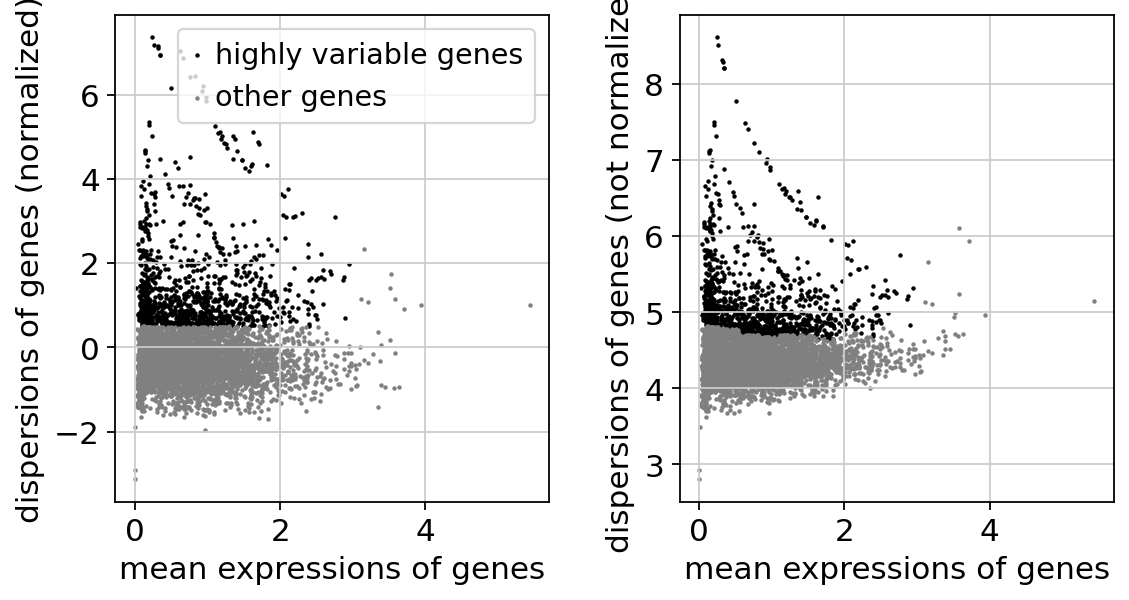

AnnData object with n_obs × n_vars = 67645 × 5001
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'median_counts', 'std_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '1.var_len_raw', '2.var_len_unique', 'qc_summary', 'log1p', 'hvg'
    layers: '1.raw_counts', '2.normalized_scale_factor=10000.0', '3.log1p'
View of AnnData object with n_obs × n_vars = 67645 × 1007
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts'

/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
AnnData object with n_obs × n_vars = 67645 × 1007
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'median_counts', 'std_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '1.var_len_raw', '2.var_len_unique', 'qc_summary', 'log1p', 'hvg'
    layers: '1.raw_counts', '2.normalized_scale_factor=10000.0', '3.log1p', '4.

In [111]:
# --- 2단계: 정규화 (Normalization) ---
# 각 세포의 라이브러리 크기(총 counts)를 동일하게 조정 (예: 10,000)
adata.layers["1.raw_counts"]=adata.X.copy()
print(adata)

scale_factor=1e4
sc.pp.normalize_total(adata, target_sum=scale_factor)
adata.layers[f"2.normalized_scale_factor={scale_factor}"]=adata.X.copy()

print(adata)
# 로그 변환 (데이터 분포 안정화 및 분산 안정화)
sc.pp.log1p(adata)
adata.layers["3.log1p"]=adata.X.copy()

print(adata)
# --- 3단계: 고분산 유전자 선택 (Highly Variable Genes, HVGs) ---
# 생물학적으로 의미 있는 변화를 보이는 유전자 식별
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata, show=True)

print(adata)
# 분석에 HVG만 사용하도록 설정 (실제 데이터 필터링은 나중에)
adata.raw = adata # 원본 데이터(정규화 및 로그 변환됨)를 .raw에 저장
adata = adata[:, adata.var.highly_variable] # HVG만 선택하여 adata 업데이트

print(adata)
# --- 4단계: 스케일링 (Scaling) ---
# 각 유전자의 발현값을 평균 0, 분산 1이 되도록 조정
# PCA와 같은 차원 축소 전에 수행
# sc.pp.scale(adata, max_value=10) # 발현값이 10을 초과하는 경우 10으로 제한(clipping)

sc.pp.scale(adata)
adata.layers["4.scale"]=adata.X.copy()

print(adata)

### SCT

In [ ]:
import sctransform

# --- 가정: adata는 초기 로딩 및 QC 필터링(세포/유전자 제거)까지만 완료됨 ---
# --- 즉, adata.X는 필터링된 raw count 상태여야 함 ---
adata=adata_origin
# 예시 QC 완료 상태의 adata
# (이전 답변의 1. 데이터 로딩 및 메타데이터 추가, 2. 품질 관리 부분 실행 완료 가정)
# print("AnnData object after QC filtering:")
# print(adata) # 이 시점의 adata.X는 raw counts

# --- SCTransform 적용 ---
# SCTransform은 scipy sparse matrix를 입력으로 받음
counts_matrix = adata.X.copy()

# SCTransform 실행 (vst: variance stabilizing transformation)
# cell_attr, gene_attr로 obs, var 데이터프레임 전달 가능
vst_out = sctransform.vst(
    counts_matrix,
    gene_names=adata.var_names.tolist(),
    cell_names=adata.obs_names.tolist(),
    method='poisson', # 또는 'nb'
    n_genes=3000,     # 식별할 HVG 수 (조정 가능)
    min_cells=5,      # 유전자가 최소 이 수의 세포에서 발현되어야 고려
    residual_type='pearson', # pearson 잔차를 주로 사용
    verbosity=1
)

# SCTransform 결과는 딕셔너리 형태
# print(vst_out.keys())
# dict_keys(['residuals', 'corrected_counts', 'model_pars', 'model_pars_fit', 'gene_attr', 'cell_attr'])

# 결과를 AnnData 객체에 저장
# 1. 잔차(Residuals): PCA 등 다운스트림 분석에 주로 사용됨
adata.layers['sct_residuals'] = vst_out['residuals']

# 2. 보정된 Count (선택적): 시각화 등에 사용 가능
adata.layers['sct_corrected_counts'] = vst_out['corrected_counts']

# 3. 식별된 고변동 유전자 정보 저장
# vst_out['gene_attr'] 데이터프레임에 HVG 정보가 있음 ('highly_variable' 컬럼)
adata.var = adata.var.join(vst_out['gene_attr'].set_index('gene_name'), how='left')
adata.var.rename(columns={'residual_variance': 'sct_residual_variance'}, inplace=True) # 이름 충돌 방지

# HVG로 플래그 지정 (sctransform > 0.1.0 기준, highly_variable 컬럼 존재)
if 'highly_variable' in adata.var.columns:
     adata.var['highly_variable'] = adata.var['highly_variable'].fillna(False)
     print(f"Identified {adata.var['highly_variable'].sum()} HVGs using SCTransform.")
else:
    # 이전 버전 호환성 또는 다른 기준 적용 필요시:
    # 예: 상위 N개 유전자를 HVG로 설정 (n_genes 파라미터 기준)
    hvg_genes = vst_out['gene_attr'].sort_values('residual_variance', ascending=False).head(3000)['gene_name'].tolist() # 예시
    adata.var['highly_variable'] = adata.var_names.isin(hvg_genes)
    print(f"Flagged top {len(hvg_genes)} genes as HVGs based on SCTransform residual variance.")


## PCA, clustering

computing PCA
    with n_comps=50
    finished (0:00:03)


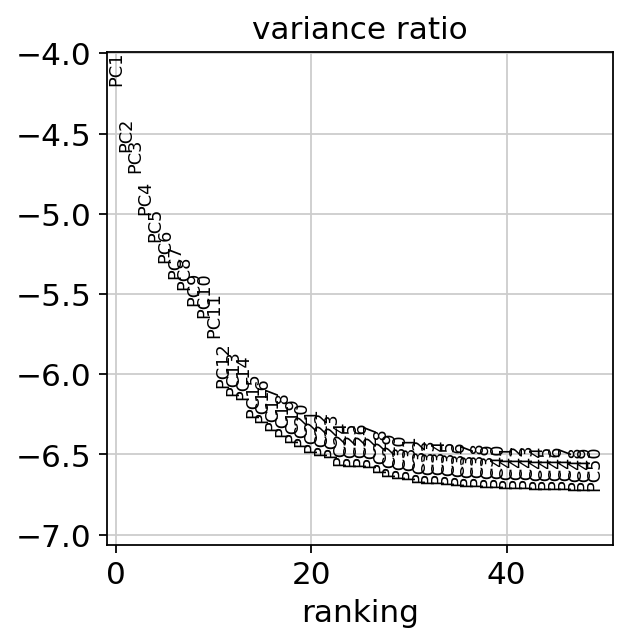

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)
running Leiden clustering


/tmp/ipykernel_140850/2073384105.py:19: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.8, key_added="clusters_leiden")


    finished: found 22 clusters and added
    'clusters_leiden', the cluster labels (adata.obs, categorical) (0:01:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:43)


KeyError: 'NKG7'

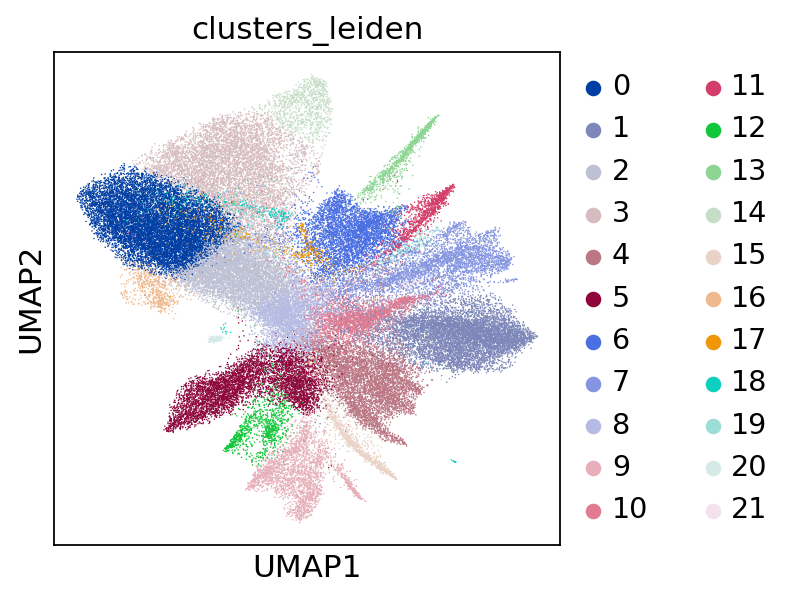

In [115]:
# --- 5단계: 차원 축소 (Dimensionality Reduction) - PCA ---
# 주성분 분석(PCA)을 수행하여 데이터의 주된 변동 축을 찾음
# n_comps: 사용할 주성분 개수. 보통 50개 정도 사용하나, elbow plot 보고 결정
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

# PCA 결과 시각화 (elbow plot으로 사용할 PC 개수 결정에 도움)
# sc.pl.pca(adata, color='NKG7', show=True) # 예시 유전자로 색칠
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50, show=True) # Elbow plot

# --- 6단계: 이웃 그래프 생성 (Neighborhood Graph) ---
# PCA 공간에서 각 세포의 가까운 이웃을 찾음 (K-Nearest Neighbors, KNN)
# n_neighbors: 각 세포마다 고려할 이웃 수
# n_pcs: 사용할 주성분(PC) 개수 (elbow plot 참고하여 결정)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

# --- 7단계: 클러스터링 (Clustering) ---
# 이웃 그래프를 기반으로 세포 군집화 (Leiden 알고리즘이 널리 사용됨)
# resolution: 클러스터 개수에 영향 (값이 크면 클러스터 수가 증가하는 경향)
sc.tl.leiden(adata, resolution=0.8, key_added="clusters_leiden")
# sc.tl.louvain(adata, resolution=0.8, key_added="clusters_louvain")

# --- 8단계: 시각화 (Visualization) - UMAP/t-SNE ---
# 고차원 데이터를 2차원으로 축소하여 시각화
# UMAP이 t-SNE보다 전역 구조를 더 잘 보존하고 계산 속도가 빠른 경향이 있음
sc.tl.umap(adata)
# sc.tl.tsne(adata, n_pcs=40) # 필요시 t-SNE도 계산 가능

# UMAP 결과 시각화 (Leiden 클러스터 또는 특정 유전자로 색칠)
sc.pl.umap(adata, color=['clusters_leiden'], show=True) # 예시 유전자 포함.. 하고싶은데 없는 게 너무 많음.

# --- (선택 사항) 클러스터 마커 유전자 찾기 ---
# 각 클러스터에서 특이적으로 발현되는 유전자(마커 유전자) 식별
# rank_genes_groups는 .raw 데이터를 사용함 (정규화+로그변환 데이터)
sc.tl.rank_genes_groups(adata, groupby='clusters_leiden', method='wilcoxon',key_added="clusters_leiden_rankgenes",reference="rest",pts =True) # Wilcoxon 순위합 검정 사용, percentage =True
#?sc.tl.rank_genes_groups
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, show=True)

# 결과 저장
adata.write('/data/kjc2/projects/P330.CSA/rds/downsampled_100_re_processed_log1p.h5ad')

In [119]:
adata

AnnData object with n_obs × n_vars = 67645 × 1007
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'clusters_leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'median_counts', 'std_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '1.var_len_raw', '2.var_len_unique', 'qc_summary', 'log1p', 'hvg', 'pca', 'neighbors', 'clusters_leiden', 'umap', 'clusters_leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: '1.r

### optional clusterings

In [ ]:
sc.tl.dbscan(adata, eps=0.5, min_samples=5, key_added="clusters_dbscan")

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=0)
adata.obs['clutsers_kmeans'] = kmeans.fit_predict(adata.obsm['X_pca'])

from scipy.cluster.hierarchy import linkage, fcluster
Z = linkage(adata.obsm['X_pca'], method='ward')
adata.obs['clutsers_hierarchical'] = fcluster(Z, t=8, criterion='maxclust')

from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=8, affinity='nearest_neighbors', random_state=0)
adata.obs['clutsers_spectral'] = spectral.fit_predict(adata.obsm['X_pca'])

#?Phenograph

# Assessment

## contingency table

In [ ]:
import pandas as pd

# adata.obs에서 'seurat_clusters'와 'disease' 열을 사용하여 contingency table 생성
contingency_table = pd.crosstab(adata.obs['clusters_leiden'], adata.obs['disease'])
print(contingency_table)

## visualization

In [52]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt","pct_counts_ribo","pct_counts_hb"],
    jitter=0.1,
    multi_panel=True,
)
adata.var_keys

KeyError: "Could not find keys ['n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts'] in columns of `adata.obs` or in adata.raw.var_names."

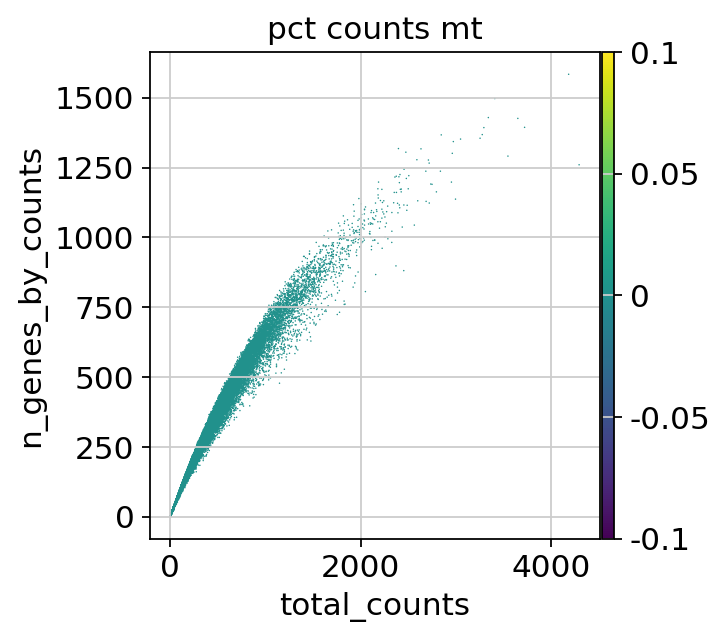

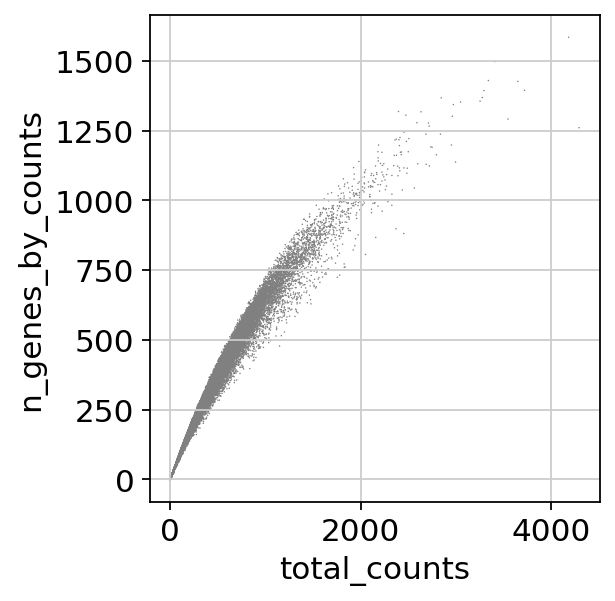

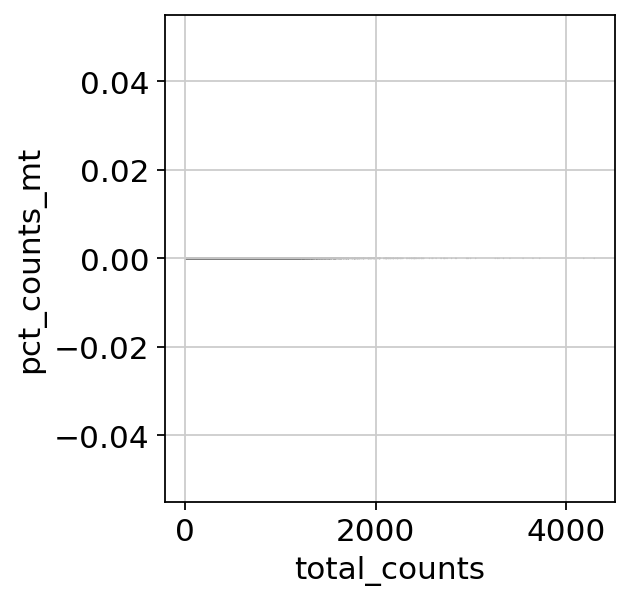

In [39]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', show=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', show=True)

# integration

## Harmony

In [44]:
import scanpy as sc
import scanpy.external as sce
import harmonypy
adata_merged=adata
# 가정: 'adata_merged'는 모든 배치가 합쳐진 AnnData 객체
# 가정: 'adata_merged.obs['batch']'에 배치 정보가 있음
# 가정: HVG 선별 및 스케일링 완료됨

# 1. PCA 수행
# sc.tl.pca(adata_merged)

# 2. Harmony 실행
# key: 배치 정보가 담긴 .obs 컬럼 이름
# basis: 입력으로 사용할 임베딩 (보통 'X_pca')
# adjusted_basis: Harmony로 보정된 임베딩이 저장될 이름 (예: 'X_pca_harmony')
sce.pp.harmony_integrate(adata_merged, key='dataset', basis='X_pca', adjusted_basis='X_pca_harmony')
# 2025-04-16 16:06:59,433 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
# 2025-04-16 16:07:02,251 - harmonypy - INFO - sklearn.KMeans initialization complete.
# 2025-04-16 16:07:02,470 - harmonypy - INFO - Iteration 1 of 10
# 2025-04-16 16:07:16,329 - harmonypy - INFO - Iteration 2 of 10
# 2025-04-16 16:07:30,020 - harmonypy - INFO - Iteration 3 of 10
# 2025-04-16 16:07:43,172 - harmonypy - INFO - Iteration 4 of 10
# 2025-04-16 16:07:56,442 - harmonypy - INFO - Iteration 5 of 10
# 2025-04-16 16:08:09,667 - harmonypy - INFO - Iteration 6 of 10
# 2025-04-16 16:08:21,024 - harmonypy - INFO - Iteration 7 of 10
# 2025-04-16 16:08:32,705 - harmonypy - INFO - Converged after 7 iterations
# 3. 보정된 임베딩 사용
# 이웃 그래프 생성 시 'X_pca_harmony' 사용
sc.pp.neighbors(adata_merged, n_pcs=30, use_rep='X_pca_harmony')
sc.tl.umap(adata_merged)
sc.pl.umap(adata_merged, color=['dataset', 'cell_type'], title=['UMAP colored by batch (after Harmony)', 'UMAP colored by cell type (after Harmony)'])

2025-04-16 16:06:59,433 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-16 16:07:02,251 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-16 16:07:02,470 - harmonypy - INFO - Iteration 1 of 10
2025-04-16 16:07:16,329 - harmonypy - INFO - Iteration 2 of 10
2025-04-16 16:07:30,020 - harmonypy - INFO - Iteration 3 of 10
2025-04-16 16:07:43,172 - harmonypy - INFO - Iteration 4 of 10
2025-04-16 16:07:56,442 - harmonypy - INFO - Iteration 5 of 10
2025-04-16 16:08:09,667 - harmonypy - INFO - Iteration 6 of 10
2025-04-16 16:08:21,024 - harmonypy - INFO - Iteration 7 of 10
2025-04-16 16:08:32,705 - harmonypy - INFO - Converged after 7 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:22)


KeyError: 'batch'

<Figure size 772.8x320 with 0 Axes>

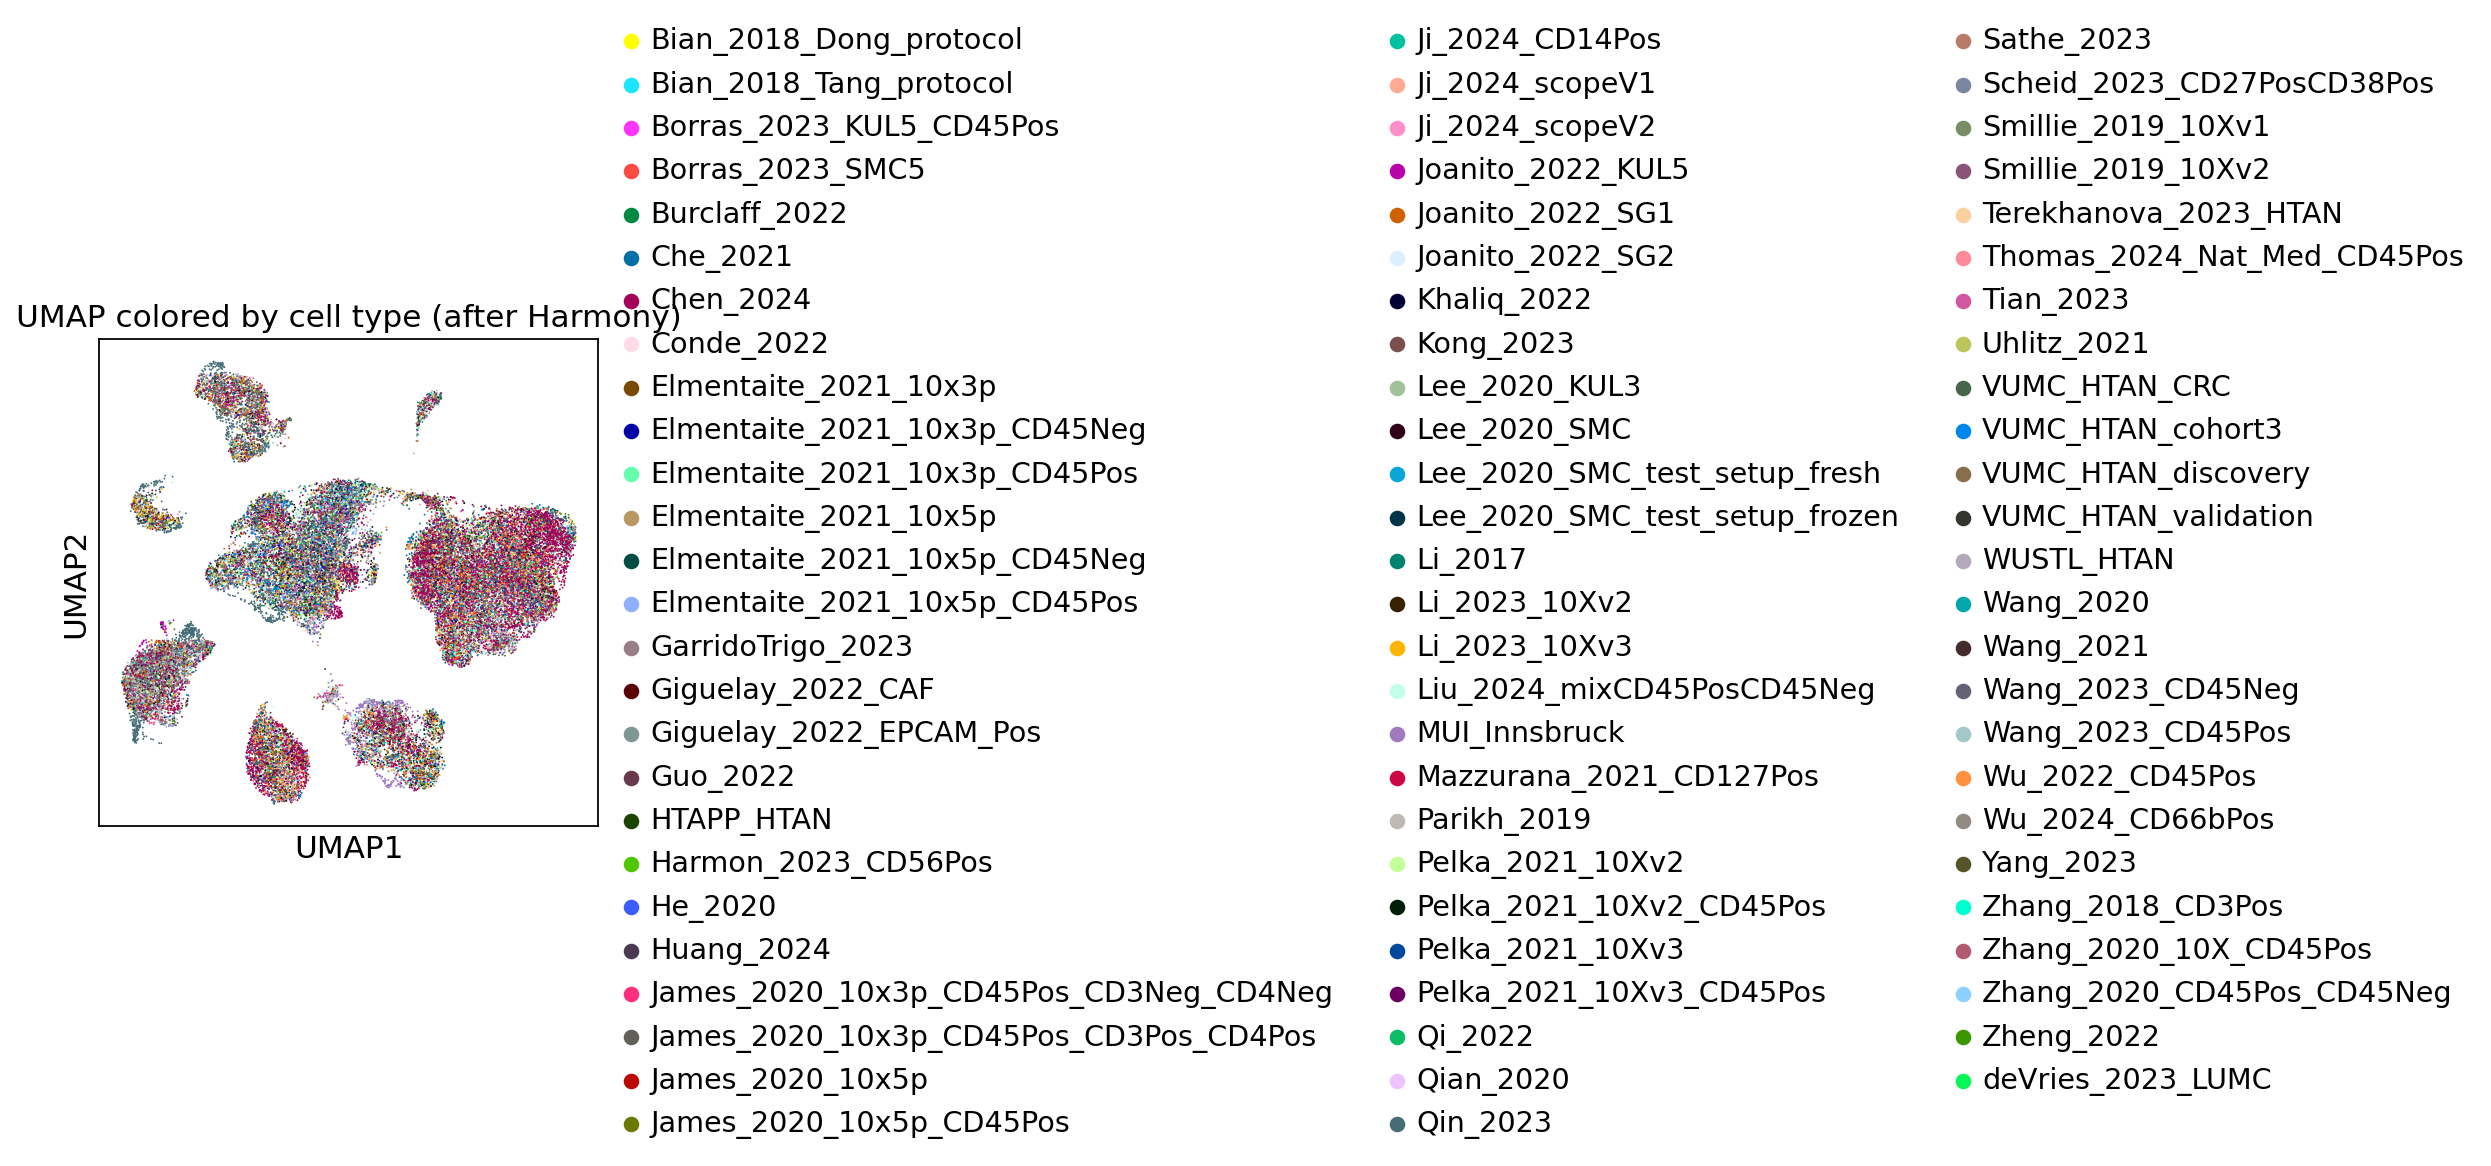

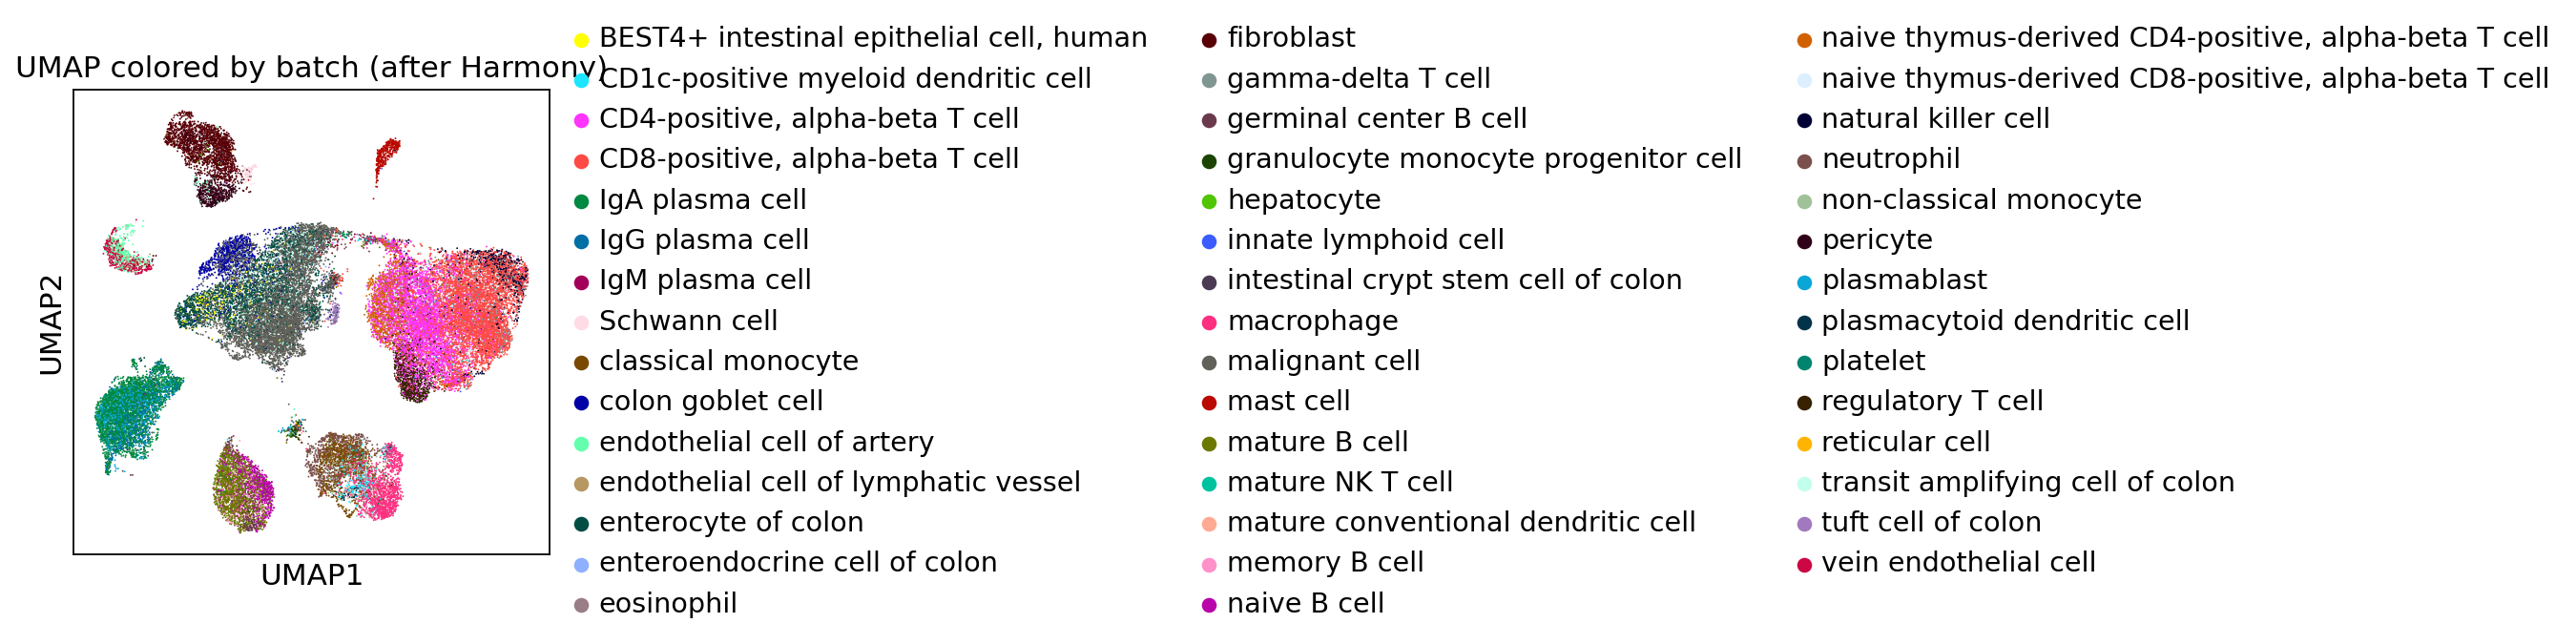

In [47]:
# sc.pl.umap(adata_merged, color=['dataset', 'cell_type'], title=['UMAP colored by batch (after Harmony)', 'UMAP colored by cell type (after Harmony)'])
sc.pl.umap(adata_merged, color=['dataset'], title=['UMAP colored by cell type (after Harmony)'])
sc.pl.umap(adata_merged, color=['cell_type'], title=['UMAP colored by batch (after Harmony)'])

### saving

In [ ]:
import datetime
now = datetime.datetime.now()
now_format = now.strftime('%Y.%m.%d.%H%M%S')
print(now_format)
adata_merged.write_h5ad(f"/data/kjc2/projects/P330.CSA/rds/downsampled_100_re_processed_log1p_harmonized_{now_format}.h5ad")

## scvi

In [ ]:
import scanpy as sc
import scvi
adata_merged=adata
# 가정: 'adata_merged'는 모든 배치가 합쳐진 AnnData 객체
# 가정: 'adata_merged.obs['batch']'에 배치 정보가 있음
# 가정: HVG 선별됨 (scVI는 내부적으로 유전자를 다시 고려할 수 있음)
# 가정: 원시 카운트가 adata_merged.layers['counts']에 있음 (또는 .X가 카운트)

# 0. 원시 카운트 데이터가 있는지 확인 및 설정 (예시)
# if 'counts' not in adata_merged.layers:
#     # .raw 에서 가져오거나 다시 로드해야 할 수 있음
#     # 예시: adata_merged.layers['counts'] = adata_merged.raw.X.copy()
#     # 또는 처음부터 카운트 데이터를 .X에 유지하고 진행

# 1. scVI 모델 설정
# batch_key: 배치 정보 컬럼
# layer: 사용할 카운트 데이터 레이어 (None이면 .X 사용)
# scvi.model.SCVI.setup_anndata(adata_merged, layer="counts", batch_key='batch')
scvi.model.SCVI.setup_anndata(adata_merged, layer="counts", batch_key='batch')

# 2. 모델 생성 및 훈련
# n_latent: 잠재 공간 차원 수
model = scvi.model.SCVI(adata_merged, n_latent=30)
model.train() # GPU 사용 가능 시 자동으로 활용

# 3. 보정된 잠재 공간 얻기
adata_merged.obsm['X_scVI'] = model.get_latent_representation()

# 4. 보정된 임베딩 사용
# 이웃 그래프 생성 시 'X_scVI' 사용
sc.pp.neighbors(adata_merged, n_pcs=30, use_rep='X_scVI')
sc.tl.umap(adata_merged)
sc.pl.umap(adata_merged, color=['dataset', 'cell_type'], title=['UMAP colored by batch (after scVI)', 'UMAP colored by cell type (after scVI)'])

# scVI는 보정된 정규화 값도 생성 가능 (선택적)
# adata_merged.layers["scvi_normalized"] = model.get_normalized_expression(library_size=1e4)

## CCA - Scanorama

In [ ]:
import scanpy as sc
import scanpy.external as sce

# 가정: 'adata_merged'는 모든 배치가 합쳐진 AnnData 객체
# 가정: 'adata_merged.obs['batch']'에 배치 정보가 있음
# 가정: HVG 선별됨, 데이터는 정규화/로그변환/스케일링 됨

# 1. Scanorama 실행 (HVG 부분집합에 대해)
# batch_key: 배치 정보 컬럼
# batch_size: 메모리 사용량 조절 (데이터 크기에 따라 조절)
adata_hvg = adata_merged[:, adata_merged.var.highly_variable].copy()
sce.pp.scanorama_integrate(adata_hvg, key='batch', basis='X', adjusted_basis='X_scanorama')

# Scanorama는 PCA 공간에서도 수행 가능
# sc.tl.pca(adata_hvg)
# sce.pp.scanorama_integrate(adata_hvg, key='batch', basis='X_pca', adjusted_basis='X_pca_scanorama')

# 2. 보정된 결과 사용
# Scanorama가 보정한 값은 원래 AnnData 객체의 HVG에 해당하는 부분에 다시 넣거나,
# 보정된 PCA를 사용할 수 있습니다. 여기서는 보정된 발현값 예시.
# 주의: Scanorama는 HVG만 보정하므로, 전체 유전자가 필요하면 주의해야 함.
# 보통 보정된 값을 기반으로 PCA를 다시 계산하고 진행합니다.

# 보정된 값을 원래 adata에 반영 (주의: HVG만 업데이트됨)
adata_merged.obsm['X_scanorama'] = adata_hvg.obsm['X_scanorama'] # 보정된 데이터 (세포 x 유전자)

# 보정된 데이터로 PCA 다시 수행 (선택적 접근)
# PCA를 보정한 경우:
# sc.pp.neighbors(adata_hvg, n_pcs=30, use_rep='X_pca_scanorama')
# sc.tl.umap(adata_hvg)
# sc.pl.umap(adata_hvg, color=['batch', 'cell_type'], title=['UMAP colored by batch (after Scanorama PCA)', 'UMAP colored by cell type (after Scanorama PCA)'])

# 발현 행렬을 보정한 경우 (보정된 값으로 PCA/Neighbors 진행):
# 이 방식은 덜 일반적일 수 있음. 보통 보정된 PCA나 scVI/Harmony latent 사용.
sc.pp.neighbors(adata_merged, use_rep='X_scanorama') # 보정된 HVG 발현값 기반 이웃 찾기
sc.tl.umap(adata_merged)
sc.pl.umap(adata_merged, color=['batch', 'cell_type'], title=['UMAP colored by batch (after Scanorama expression)', 'UMAP colored by cell type (after Scanorama expression)'])

# merging

In [ ]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd

# --- 예시 데이터 생성 ---
# 실제로는 sc.read_10x_mtx, sc.read_h5ad 등으로 로드합니다.
adata_A = ad.AnnData(X=np.random.rand(100, 500),
                     obs=pd.DataFrame({'batch_orig': ['A1'] * 50 + ['A2'] * 50}, index=[f'A_cell_{i}' for i in range(100)]),
                     var=pd.DataFrame(index=[f'Gene_{i}' for i in range(500)]))
adata_B = ad.AnnData(X=np.random.rand(150, 600),
                     obs=pd.DataFrame({'batch_orig': ['B1'] * 70 + ['B2'] * 80}, index=[f'B_cell_{i}' for i in range(150)]),
                     var=pd.DataFrame(index=[f'Gene_{i}' for i in range(150, 750)])) # 유전자 일부 겹치고 일부 다름

print("A data:", adata_A)
print("B data:", adata_B)

# --- AnnData 객체 합치기 ---
# join='inner': 두 데이터셋에 공통으로 존재하는 유전자만 유지
# join='outer': 모든 유전자를 유지하고, 없는 경우 0으로 채움 (메모리 주의)
# batch_key: 합쳐진 AnnData의 .obs에 추가될 컬럼 이름 (어떤 원본 데이터에서 왔는지 표시)
# batch_categories: batch_key 컬럼에 들어갈 값 (원본 데이터셋 이름 지정)
# index_unique: 세포 ID가 겹칠 경우 고유하게 만들기 위해 접미사 추가 (예: '-A', '-B')
adata_merged = adata_A.concatenate(adata_B,
                                  join='inner', # 공통 유전자만 사용
                                  batch_key='dataset_source',
                                  batch_categories=['SetA', 'SetB'],
                                  index_unique=None) # 세포 ID가 원래 고유하다면 None

print("\nMerged data:", adata_merged)
print("\nMerged obs head:\n", adata_merged.obs.head())
print("\nMerged obs tail:\n", adata_merged.obs.tail())
print("\nUnique dataset sources:", adata_merged.obs['dataset_source'].unique())

## new batch key

In [ ]:
# 가정: 'adata_merged'는 위 2번에서 생성된 합쳐진 객체
# 'dataset_source' 컬럼과 'batch_orig' 컬럼이 .obs에 존재

# 1. 두 컬럼을 문자열로 변환하여 합치기
adata_merged.obs['integrated_batch'] = adata_merged.obs['dataset_source'].astype(str) + '_' + \
                                       adata_merged.obs['batch_orig'].astype(str)

# 2. 결과 확인
print("\nObs with new integrated batch key:\n", adata_merged.obs.head())
print("\nUnique integrated batch keys:", adata_merged.obs['integrated_batch'].unique())

# 이제 'integrated_batch' 컬럼을 위 1번의 integration 메소드들의 'key' 파라미터로 사용할 수 있습니다.
# 예: sce.pp.harmony_integrate(adata_merged, key='integrated_batch', ...)
# 예: scvi.model.SCVI.setup_anndata(adata_merged, layer="counts", batch_key='integrated_batch')